# Chapter 6 - Latent-mixture models

In [1]:
using Pkg
using Logging
using DynamicPPL, Turing
using Zygote, ReverseDiff
using StatsPlots, Random
using LaTeXStrings
using CSV
using DataFrames
using SpecialFunctions
using LinearAlgebra
using FillArrays
using CSV, DataFrames
using LogExpFunctions
using KernelDensity

In [2]:
format=:png

:png

In [3]:
Random.seed!(6)

TaskLocalRNG()

## 6.1 Exam scores
$$ z_{i} \sim \text{Bernoulli}(0.5)  $$
$$ \phi \sim \text{Uniform}(0.5, 1) $$
$$ \psi = 0.5 $$  
$$   \theta_{i} \sim
\begin{cases}
\phi  & \text{if $z_{i} = 1$} \\
\psi  & \text{if $z_{i} = 0$}
\end{cases}  $$
$$ k_{i} \sim \text{Binomial}(\theta_{i}, n) $$

┌ Info: Found initial step size
└   ϵ = 0.4
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


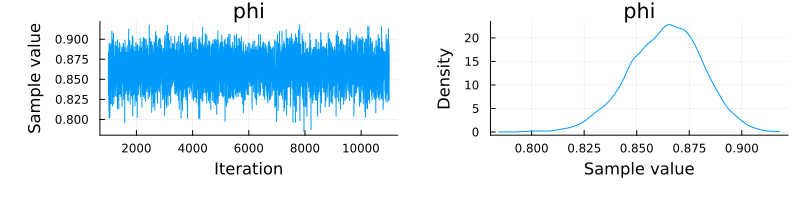

In [4]:
x = [21, 17, 21, 18, 22, 31, 31, 34, 34, 35, 35, 36, 39, 36, 35];
num_people = length(x)
num_question = 40
psi = 0.5

function exam_loglikelihood(e, p)
    return log(0.5) + loglikelihood(Binomial(num_question, p), e)
end

@model function ExamScores(x)
    phi ~ Uniform(0.5, 1.0)

    for i in eachindex(x)
        Turing.@addlogprob! logsumexp([exam_loglikelihood(x[i], psi), exam_loglikelihood(x[i], phi)])
    end
end

iterations = 10_000
burnin = 1000

model_exam_scores = ExamScores(x)
chain = sample(model_exam_scores, NUTS(), iterations, burnin=burnin)
plot(chain, size=(800, 200), left_margin=10Plots.mm, bottom_margin=10Plots.mm, fmt=format)

In [5]:
chain

Chains MCMC chain (10000×13×1 Array{Float64, 3}):

Iterations        = 1001:1:11000
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 8.06 seconds
Compute duration  = 8.06 seconds
parameters        = phi
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse    ess_bulk    ess_tail      rhat   ⋯
      Symbol   Float64   Float64   Float64     Float64     Float64   Float64   ⋯

         phi    0.8636    0.0174    0.0002   6757.6793   7148.4507    1.0000   ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

         phi    0.8278    0.8520    0.8644    0.8758    0.8959


## 6.2 Exam scores with individual differences


$$ z_{i} \sim \text{Bernoulli}(0.5)  $$
$$ \mu \sim \text{Uniform}(0.5, 1) $$
$$ \lambda \sim \text{Gamma}(.001, .001)$$  
$$ \phi_{i} \sim \text{Gaussian}(\mu, \lambda)_{\mathcal I(0,1)} $$
$$ \psi = 0.5 $$  
$$   \theta_{i} \sim
\begin{cases}
\phi_{i}  & \text{if $z_{i} = 1$} \\
\psi  & \text{if $z_{i} = 0$}
\end{cases}  $$
$$ k_{i} \sim \text{Binomial}(\theta_{i}, n) $$

In [6]:
y = [21, 17, 21, 18, 22, 31, 31, 34, 34, 35, 35, 36, 39, 36, 35]
num_people = length(y)
num_question = 40
psi = 0.5

function exam_loglikelihood_individual_differences(e, p)
    return log(0.5) + loglikelihood(Binomial(num_question, p), e)
end

@model function ExamScoresIndividualDifferences(y)
    mu ~ Uniform(0.5, 1.0)
    lambda ~ truncated(Gamma(0.001, 1 / 0.001), lower=1e-15, upper=10_000)
    phi ~ filldist(truncated(Normal(mu, 1.0 / sqrt(lambda)), lower=0, upper=1), length(y))

    for i in eachindex(y)
        log_prob_parts = [
            exam_loglikelihood_individual_differences(y[i], psi),
            exam_loglikelihood_individual_differences(y[i], phi[i])
        ]
        Turing.@addlogprob! logsumexp(log_prob_parts)
    end
end

iterations = 10_000
burnin = 10_000

model_exam_scores_individual_differences = ExamScoresIndividualDifferences(y)
chain = sample(model_exam_scores_individual_differences, NUTS(), iterations, burnin=burnin)

┌ Info: Found initial step size
└   ϵ = 0.05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:06


Chains MCMC chain (10000×29×1 Array{Float64, 3}):

Iterations        = 1001:1:11000
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 11.63 seconds
Compute duration  = 11.63 seconds
parameters        = mu, lambda, phi[1], phi[2], phi[3], phi[4], phi[5], phi[6], phi[7], phi[8], phi[9], phi[10], phi[11], phi[12], phi[13], phi[14], phi[15]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters       mean        std      mcse    ess_bulk    ess_tail      rhat ⋯
      Symbol    Float64    Float64   Float64     Float64     Float64   Float64 ⋯

          mu     0.8701     0.0355    0.0009   1884.3975   1564.6791    0.9999 ⋯
      lambda   581.1297   627.3758   36.8015    617.8060    356.4243    1.0000 ⋯
      phi[1]     0.8553     0.0705    0.0009   5690.4724   3210.9659    1.0000 ⋯
      phi[2] 

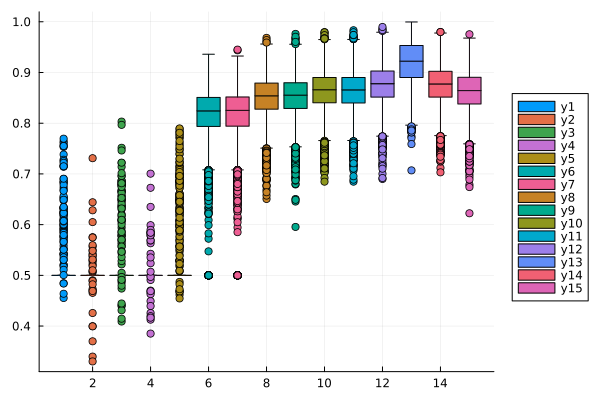

In [7]:
list_of_plot = []
for i in 1:15
    v = chain["phi[$i]"] |> collect
    z = [rand(Bernoulli(p)) for p in [softmax([
        exam_loglikelihood_individual_differences(y[i], 0.5),
        exam_loglikelihood_individual_differences(y[i], e)
    ])[2] for e in v]]

    push!(list_of_plot, vcat(0.5 * ones(length(v) - sum(z)), v[z]))
end

boxplot(list_of_plot; legend=:outerright, outlier=true, fmt=format)

## 6.3 Twenty questions


Suppose a group of 10 people attend a lecture, and are asked a set of 20 questions afterwards, with every answer being either correct or incorrect.  
$$ p_{i},q_{j} \sim \text{Beta}(1,1)$$
$$ \theta_{ij} = p_{i}q_{j} $$
$$ k_{ij} \sim \text{Bernoulli}(\theta_{ij}) $$ 

In [8]:
choose_dataset = 2

data_1 = [
    1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0
    1 0 1 0 0 0 0 0 0 0 1 1 0 1 0 0 1 0 0 0
    1 1 1 0 1 1 0 0 1 1 0 1 0 0 0 0 1 1 0 1
    1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0
    0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
    0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0
    1 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0
    1 1 0 0 1 0 0 0 1 1 1 1 0 0 0 0 1 1 0 0
    0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
    1 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 1 1 1 0
];

data_2 = [
    1 1 1 1 0 0 1 1 0 1 0 0 missing 0 0 1 0 1 0 0
    0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
    0 0 1 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0
    0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0
    1 0 1 1 0 1 1 1 0 1 0 0 1 0 0 0 0 1 0 0
    1 1 0 1 0 0 0 1 0 1 0 1 1 0 0 1 0 1 0 0
    0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
    0 0 0 0 missing 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
    0 1 1 0 0 0 0 1 0 1 0 0 1 0 0 0 0 1 0 1
    1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 missing 0 0
]

if choose_dataset == 1
    k = data_1
else
    k = data_2
end

10×20 Matrix{Union{Missing, Int64}}:
 1  1  1  1  0         0  1  1  0  1  0  0  …  0  0  1  0  1         0  0
 0  1  1  0  0         0  0  0  0  0  0  0     0  0  0  0  0         0  0
 0  0  1  0  0         0  1  1  0  0  0  0     0  0  0  0  0         0  0
 0  0  0  0  0         0  1  0  1  1  0  0     0  0  0  0  0         0  0
 1  0  1  1  0         1  1  1  0  1  0  0     0  0  0  0  1         0  0
 1  1  0  1  0         0  0  1  0  1  0  1  …  0  0  1  0  1         0  0
 0  0  0  0  0         0  0  0  0  0  0  1     0  0  0  0  0         0  0
 0  0  0  0   missing  0  0  0  0  0  0  0     0  0  0  0  0         0  0
 0  1  1  0  0         0  0  1  0  1  0  0     0  0  0  0  1         0  1
 1  0  0  0  0         0  1  0  0  1  0  0     0  0  0  0   missing  0  0

In [9]:
n_p, n_q = size(k,1), size(k,2)

(10, 20)

In [10]:
@model function TwentyQuestions(k)
    pi ~ filldist(Beta(1.0, 1.0), n_p)
    qi ~ filldist(Beta(1.0, 1.0), n_q)

    theta = pi .* qi'

    for i in 1:n_p
        for j in 1:n_q
            if !ismissing(k[i, j])
                k[i, j] ~ Bernoulli(theta[i, j])
            end
        end
    end

end

TwentyQuestions (generic function with 2 methods)

In [11]:
iterations = 2_000
burnin = 2_00

model_twenty_questions = TwentyQuestions(k)
chain = sample(model_twenty_questions, NUTS(), iterations, burnin=burnin)

┌ Info: Found initial step size
└   ϵ = 1.6
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:09


Chains MCMC chain (2000×42×1 Array{Float64, 3}):

Iterations        = 1001:1:3000
Number of chains  = 1
Samples per chain = 2000
Wall duration     = 13.85 seconds
Compute duration  = 13.85 seconds
parameters        = pi[1], pi[2], pi[3], pi[4], pi[5], pi[6], pi[7], pi[8], pi[9], pi[10], qi[1], qi[2], qi[3], qi[4], qi[5], qi[6], qi[7], qi[8], qi[9], qi[10], qi[11], qi[12], qi[13], qi[14], qi[15], qi[16], qi[17], qi[18], qi[19], qi[20]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse    ess_bulk    ess_tail      rhat   ⋯
      Symbol   Float64   Float64   Float64     Float64     Float64   Float64   ⋯

       pi[1]    0.8760    0.1098    0.0020   2688.7650   1435.2553    0.9995   ⋯
       pi[2]    0.2754    0.1395    0.0026   3071.1026   1456.0573    1.0001   ⋯
       pi[3] 

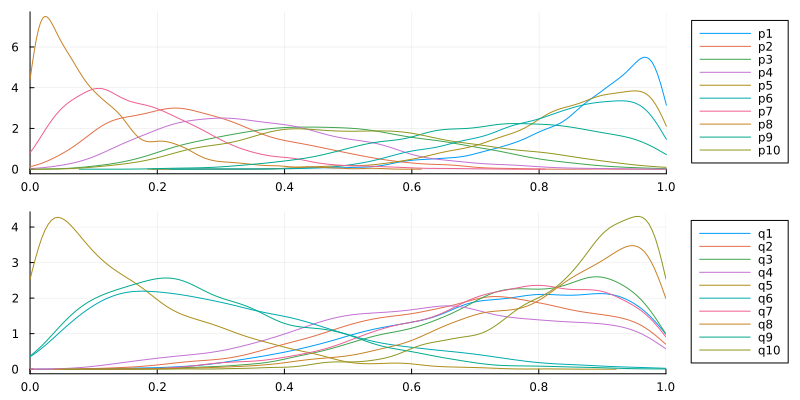

In [12]:
p_plot = density(chain["pi[1]"], label="p1")
for i in 2:n_p
    density!(chain["pi[$i]"], label="p$i")
end

xlims!(0, 1)
plot(p_plot, size=(800, 200); legend=:outerright)

q_plot = density(chain["qi[1]"], label="q1")
for i in 2:n_p
    density!(chain["qi[$i]"], label="q$i")
end

xlims!(0, 1)
plot(q_plot, size=(800, 200); legend=:outerright)

plot(p_plot, q_plot, size=(800, 400), layout=(2, 1), legend=:outerright, fmt=format)

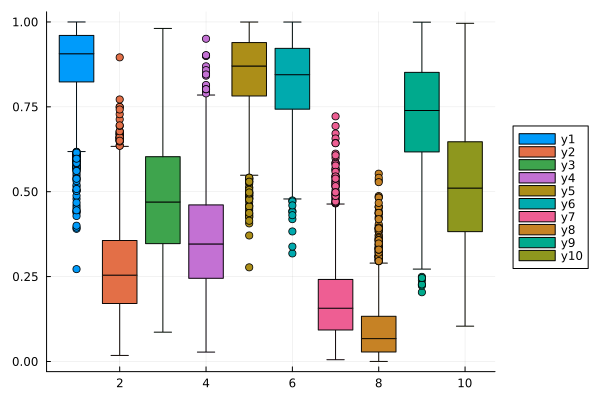

In [13]:
list_of_plot = []
for i in 1:n_p
    v = chain["pi[$i]"] |> collect
    push!(list_of_plot, v)
end

boxplot(list_of_plot; legend=:outerright, outlier=true, fmt=format)

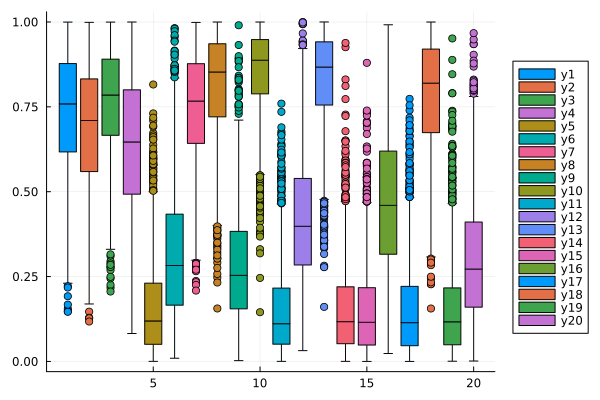

In [14]:
list_of_plot = []
for i in 1:n_q
    v = chain["qi[$i]"] |> collect
    push!(list_of_plot, v)
end

boxplot(list_of_plot; legend=:outerright, outlier=true, fmt=format)

## 6.4 The two-country quiz


$$ \alpha \sim \text{Uniform}(0,1) $$
$$ \beta \sim \text{Uniform}(0,\alpha) $$
$$ x_{i} \sim \text{Bernoulli}(0.5) $$
$$ z_{j} \sim \text{Bernoulli}(0.5) $$
$$   \theta_{ij} \sim
\begin{cases}
\alpha  & \text{if $x_{i} = z_{j}$} \\
\beta  & \text{if $x_{i} \neq z_{j}$}
\end{cases}  $$
$$ k_{ij} \sim \text{Bernoulli}(\theta_{ij}) $$ 

In [15]:
# TODO: WIP

## 6.5 Assessment of malingering


$$ \psi^b \sim \text{Uniform}(0.5,1) $$
$$ \psi^m \sim \text{Uniform}(0,\psi^b) $$
$$ z_{i} \sim \text{Bernoulli}(0.5) $$
$$   \theta_{ij} \sim
\begin{cases}
\psi^b  & \text{if $z_{i} = 0$} \\
\psi^m  & \text{if $z_{i} = 1$}
\end{cases}  $$
$$ k_{i} \sim \text{Binomial}(\theta_{i},n) $$ 

In [16]:
k = [45,45,44,45,44,45,45,45,45,45,30,20,6,44,44,27,25,17,14,27,35,30]
p = length(k)  # number of people
n = 45  # number of questions

45

In [17]:
function malingering_loglikelihood(e, p)
    return log(0.5) + loglikelihood(Binomial(n, p), e)
end

@model function AsessmentOfMalingering(k)
    psi_b ~ Uniform(0.5, 1)
    psi_m ~ Uniform(0, psi_b)
    
    for i in eachindex(k)
        Turing.@addlogprob! logsumexp([malingering_loglikelihood(k[i], psi_b), malingering_loglikelihood(k[i], psi_m)])
    end 
end

AsessmentOfMalingering (generic function with 2 methods)

In [18]:
iterations = 5_000
burnin = 2_000

model_malingering = AsessmentOfMalingering(k)

sampler = Gibbs(PG(60, :zi), NUTS(1000, 0.95, :psi_b, :psi_m))
sampler = NUTS()
chain = sample(model_malingering, sampler, iterations, burnin=burnin)

┌ Info: Found initial step size
└   ϵ = 0.05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (5000×14×1 Array{Float64, 3}):

Iterations        = 1001:1:6000
Number of chains  = 1
Samples per chain = 5000
Wall duration     = 3.55 seconds
Compute duration  = 3.55 seconds
parameters        = psi_b, psi_m
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse    ess_bulk    ess_tail      rhat   ⋯
      Symbol   Float64   Float64   Float64     Float64     Float64   Float64   ⋯

       psi_b    0.9907    0.0041    0.0001   4814.5755   3334.3599    1.0000   ⋯
       psi_m    0.3073    0.0143    0.0002   4563.7220   3895.3421    1.0000   ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

  

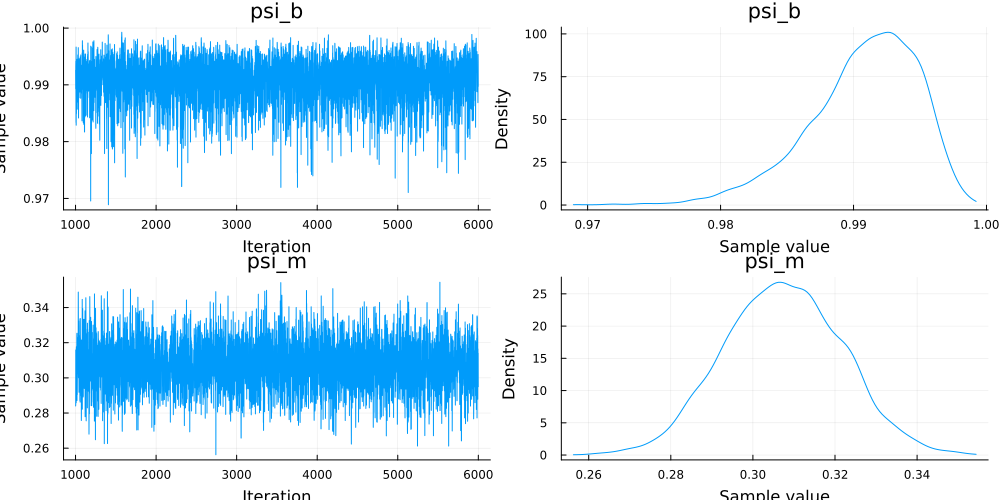

In [19]:
plot(chain, fmt=format)

## 6.6 Individual differences in malingering


$$ \mu_{b} \sim \text{Beta}(1,1) $$
$$ \mu_{d} \sim \text{Gaussian}(0,0.5)_{\mathcal I(0,∞)} $$
$$ \lambda_{b} \sim \text{Uniform}(40,800) $$
$$ \lambda_{m} \sim \text{Uniform}(4,100) $$
$$ z_{i} \sim \text{Bernoulli}(\phi) $$
$$   \theta_{i} \sim
\begin{cases}
\text{Beta}(\mu_{b}\lambda_{b},(1-\mu_{b})\lambda_{b})  & \text{if $z_{i} = 0$} \\
\text{Beta}(\mu_{m}\lambda_{m},(1-\mu_{m})\lambda_{m})  & \text{if $z_{i} = 1$}
\end{cases}  $$
$$ k_{i} \sim \text{Binomial}(\theta_{i},n) $$ 
$$ \text{logit}\mu_{m} = \text{logit}\mu_{b} - \mu_{d} $$
$$ \phi \sim \text{Beta}(5,5)$$

In [20]:
k = [45,45,44,45,44,45,45,45,45,45,30,20,6,44,44,27,25,17,14,27,35,30]
p = length(k)  # number of people
n = 45  # number of questions

45

In [21]:
@model function AsessmentOfMalingering2(k)
    mubon ~ Beta(1, 1)
    mudiff ~ truncated(Normal(0, 1 / sqrt(.5)), lower=0)
    phi ~ Beta(5, 5)
    
    lambdabon ~ Uniform(40, 800)
    lambdamal ~ Uniform(4, 100)
    
    mumal = logistic(logit(mubon) - mudiff)
    
    alpha_1 = mubon * lambdabon
    beta_1 = lambdabon * (1 - mubon)
    alpha_2 = mumal * lambdamal
    beta_2 = lambdamal * (1 - mumal)
    
    for i in eachindex(k)
        theta_1 ~ Beta(alpha_1, beta_1)
        theta_2 ~ Beta(alpha_2, beta_2)
        
        log_prob_parts = [
            log(1 - phi) + loglikelihood(Binomial(n, theta_1), k[i]),
            log(phi) + loglikelihood(Binomial(n, theta_2), k[i])
        ]
        Turing.@addlogprob! logsumexp(log_prob_parts)
    end 
end

AsessmentOfMalingering2 (generic function with 2 methods)

In [22]:
iterations = 5_000
burnin = 2_000

model_malingering2 = AsessmentOfMalingering2(k)
sampler = NUTS()
chain = sample(model_malingering2, sampler, iterations, burnin=burnin)

┌ Info: Found initial step size
└   ϵ = 0.05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:05


Chains MCMC chain (5000×19×1 Array{Float64, 3}):

Iterations        = 1001:1:6000
Number of chains  = 1
Samples per chain = 5000
Wall duration     = 12.7 seconds
Compute duration  = 12.7 seconds
parameters        = mubon, mudiff, phi, lambdabon, lambdamal, theta_1, theta_2
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters       mean       std      mcse    ess_bulk    ess_tail      rhat  ⋯
      Symbol    Float64   Float64   Float64     Float64     Float64   Float64  ⋯

       mubon     0.9681    0.0080    0.0002   2280.3896   2759.9929    0.9999  ⋯
      mudiff     3.3793    0.2657    0.0054   2395.8248   2786.6139    1.0000  ⋯
         phi     0.4664    0.0892    0.0013   4615.1989   2996.3230    1.0008  ⋯
   lambdabon   735.1961   59.0944    0.8359   3326.8658   2077.9180    0.9999  ⋯
   lambdamal   

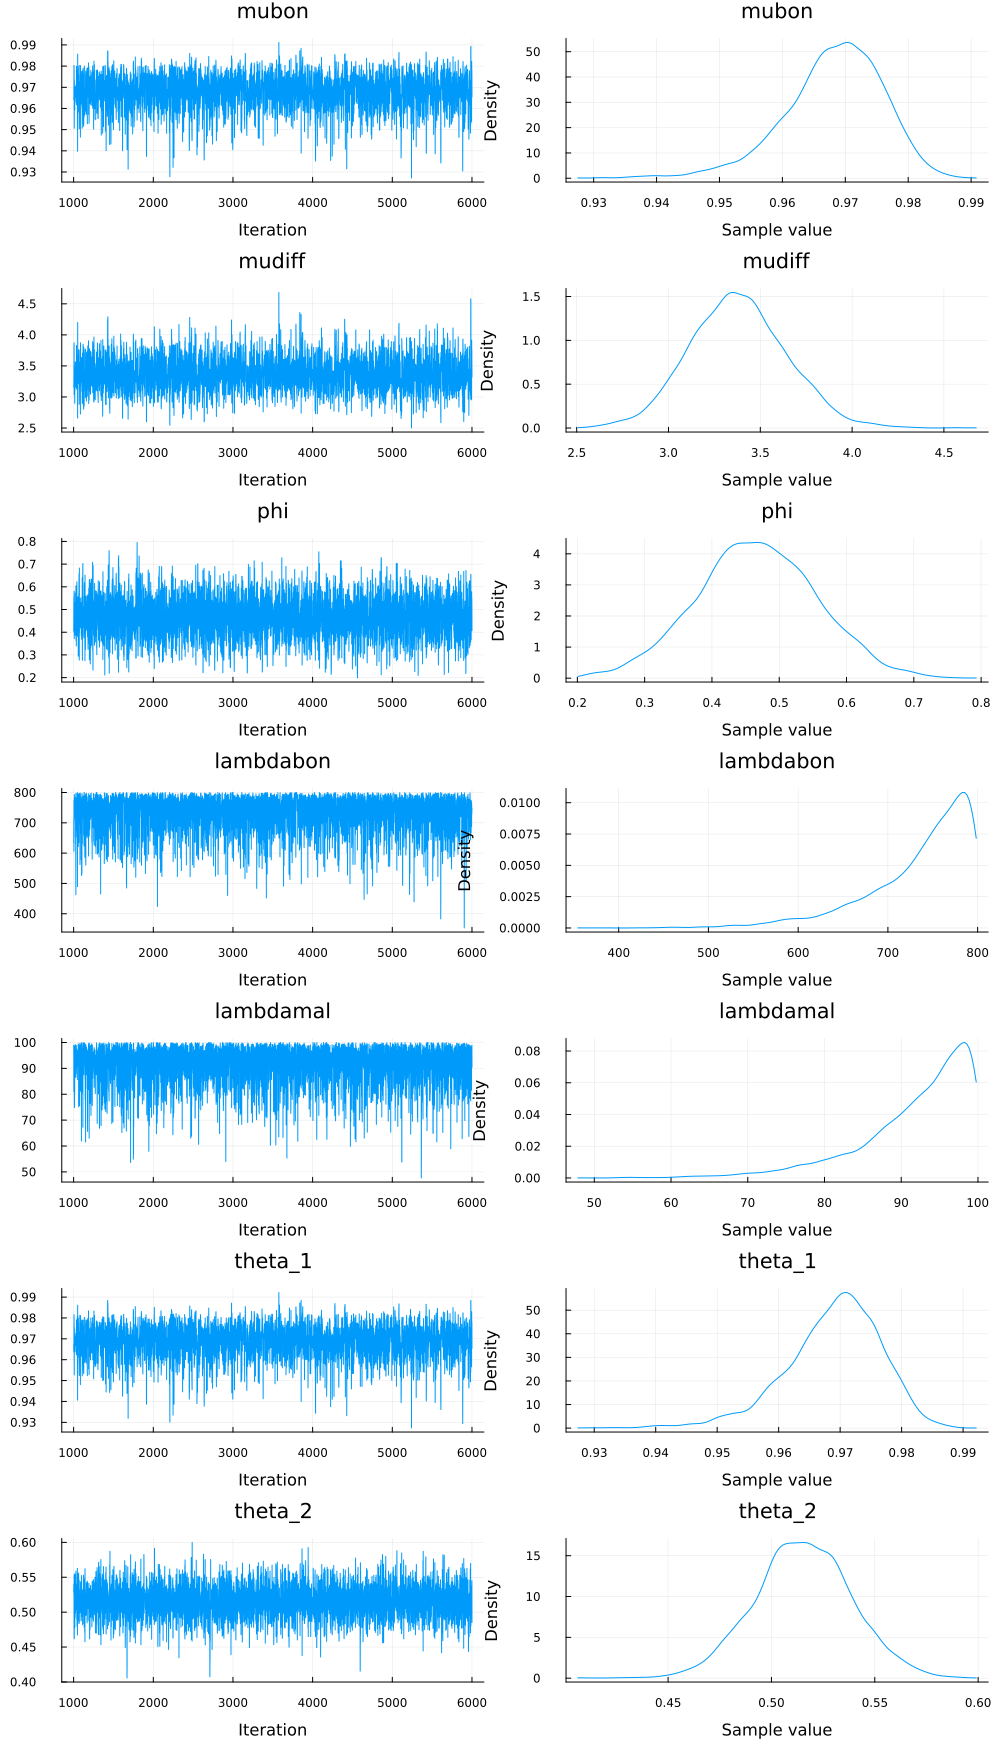

In [23]:
plot(chain, fmt=format)

## 6.7 Alzheimer's recall test cheating


$$ \mu_{b} \sim \text{Beta}(1,1) $$
$$ \mu_{d} \sim \text{Gaussian}(0,0.5)_{\mathcal I(0,∞)} $$
$$ \lambda_{b} \sim \text{Uniform}(5,50) $$
$$ \lambda_{c} \sim \text{Uniform}(5,50) $$
$$ z_{i} \sim \text{Bernoulli}(\phi) $$
$$   \theta_{i} \sim
\begin{cases}
\text{Beta}(\mu_{b}\lambda_{b},(1-\mu_{b})\lambda_{b})  & \text{if $z_{i} = 0$} \\
\text{Beta}(\mu_{c}\lambda_{c},(1-\mu_{c})\lambda_{c})  & \text{if $z_{i} = 1$}
\end{cases}  $$
$$ k_{i} \sim \text{Binomial}(\theta_{i},n) $$ 
$$ \text{logit}\mu_{c} = \text{logit}\mu_{b} + \mu_{d} $$
$$ \phi \sim \text{Beta}(5,5)$$

In [24]:
# TODO: WIP

In [25]:
Pkg.status()

Status `~/quangtiencs_projects/bayesian-cognitive-modeling-with-turing.jl/Project.toml`
  [336ed68f] CSV v0.10.11
  [a93c6f00] DataFrames v1.6.1
⌃ [366bfd00] DynamicPPL v0.23.0
  [7073ff75] IJulia v1.24.2
  [5ab0869b] KernelDensity v0.6.7
  [b964fa9f] LaTeXStrings v1.3.0
  [2ab3a3ac] LogExpFunctions v0.3.24
  [91a5bcdd] Plots v1.38.17
  [37e2e3b7] ReverseDiff v1.15.0
  [276daf66] SpecialFunctions v2.3.0
  [f3b207a7] StatsPlots v0.15.6
  [fce5fe82] Turing v0.28.1
  [e88e6eb3] Zygote v0.6.62
Info Packages marked with ⌃ have new versions available and may be upgradable.
